### Import libraries

In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings; warnings.filterwarnings("ignore")
from math import sqrt
from nsepy import get_history as gh
import datetime as dt
import time

from sklearn.model_selection import train_test_split
from sklearn import model_selection
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR, LinearSVR
from lightgbm import LGBMRegressor
#import optuna.integration.lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
import xgboost as xgb

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from IPython.display import display
import gc

from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, confusion_matrix, mean_absolute_error

In [4]:
def featuring(train):
    dfa=pd.DataFrame()
    for code in train['SecuritiesCode'].unique():
        df=train[train['SecuritiesCode']==code]
        df=df.sort_values(by=['Date'], ascending=True)
        df['RA_20'] = df.Close.rolling(5, min_periods=1).mean()
        df['RA_40'] = df.Close.rolling(10, min_periods=1).mean()
        df['RA_60'] = df.Close.rolling(15, min_periods=1).mean()
        df['RA_80'] = df.Close.rolling(20, min_periods=1).mean()
        dfa=dfa.append(df)
    dfa['Quarter'] = dfa['Date'].apply(lambda time: pd.Timestamp(time).quarter)
    dfa['year']=pd.to_numeric(dfa['Date'].str[0:4]).astype(float)
    dfa['month']=pd.to_numeric(dfa['Date'].str[4:6]).astype(float)
    dfa['day']=pd.to_numeric(dfa['Date'].str[6:8]).astype(float)
    dfa['delta']=pd.to_numeric(dfa['High']-dfa['Low']).astype(float)
    dfa['change']=pd.to_numeric(dfa['Close']-dfa['Open']).astype(float)
    dfa=dfa[['Date','SecuritiesCode','delta','change','RA_20','RA_40','RA_60','year','month','day','Quarter']]
    train=train.merge(dfa,how='left',on=['Date','SecuritiesCode'],suffixes=('', 'b')).set_axis(train.index)
    return train

In [5]:
def _calc_spread_return_per_day(df, portfolio_size= 200, toprank_weight_ratio= 2):
    """
    Args:
        df (pd.DataFrame): predicted results
        portfolio_size (int): # of equities to buy/sell
        toprank_weight_ratio (float): the relative weight of the most highly ranked stock compared to the least.
    Returns:
        (float): spread return
    """
    df["Rank"] = df["Target"].rank(ascending=False,method="first") -1
    weights = np.linspace(start=toprank_weight_ratio, stop=1, num=portfolio_size)
    purchase = (df.sort_values(by='Rank')['Target'][:portfolio_size] * weights).sum() / weights.mean()
    short = (df.sort_values(by='Rank', ascending=False)['Target'][:portfolio_size] * weights).sum() / weights.mean()
    return purchase - short
# buf = prices.groupby('Date').apply(_calc_spread_return_per_day)
# sharpe_ratio = buf.mean() / buf.std()
# sharpe_ratio

### Load data

In [4]:
supplemental_prices = pd.read_csv('supplemental_files/stock_prices.csv')
supplemental_sprices = pd.read_csv('supplemental_files/secondary_stock_prices.csv')
prices = pd.read_csv('train_files/stock_prices.csv')
#stock_list = pd.read_csv('stock_list.csv')
sprices = pd.read_csv('train_files/secondary_stock_prices.csv')

In [5]:
prices=prices.append(sprices,ignore_index=True)
prices=prices.append(supplemental_prices,ignore_index=True)
prices=prices.append(supplemental_sprices,ignore_index=True)
prices=prices.drop(['RowId','ExpectedDividend'],axis=1)
prices=prices.dropna()

In [6]:
prices['Date'] = prices['Date'].str.replace('-','')
prices = featuring(prices)
train_prices = prices[prices['Date']<'20220201']
train_prices = train_prices.drop(['Date'],axis=1)
test_prices = prices[prices['Date']>='20220201']
sharp_dataframe = pd.DataFrame()
sharp_dataframe['Date'] = test_prices['Date']
sharp_dataframe['SecuritiesCode'] = test_prices['SecuritiesCode']
test_prices = test_prices.drop(['Date'],axis=1)

In [27]:
ground_truth_sharp = prices[prices['Date']>='20220201']
buf = ground_truth_sharp.groupby('Date').apply(_calc_spread_return_per_day)
sharpe_ratio = buf.mean() / buf.std()
sharpe_ratio

6.593815176452243

In [7]:
y_train = train_prices.pop('Target')
y_test = test_prices.pop('Target')
X_train = train_prices
X_test = test_prices

gc.collect()

41

## Preprocessing

In [8]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Linear Regression

In [10]:
## Train the model
model_linear = LinearRegression()
start = time.time()
model_linear.fit(X_train, y_train)

## Predict in test data
y_pred_linear = model_linear.predict(X_test)

end = time.time()
print(end - start)

2.9221463203430176


In [11]:
##Evaluate the model
print("Linear Regression")

#Mean Squared Error (MSE)
mse_linear = mean_squared_error(y_test, y_pred_linear)
#Mean Absolute Error (MAE)
mae_linear = mean_absolute_error(y_test, y_pred_linear)
#Mean Absolute Percentage Error (MAPE)
mape_linear = mean_absolute_percentage_error(y_test, y_pred_linear)
#Root Mean Squared Error (RMSE)
rmse_linear = mean_squared_error(y_test, y_pred_linear, squared = False)

print("Mean Squared Error: ", mse_linear)
print("Mean Absolute Error: ", mae_linear)
print("Mean Absolute Percentage Error: ", mape_linear)
print("Root Mean Squared Error: ", rmse_linear)

Linear Regression
Mean Squared Error:  0.000696423969064952
Mean Absolute Error:  0.01662224780488568
Mean Absolute Percentage Error:  96148974293.4194
Root Mean Squared Error:  0.026389845946214845


In [12]:
sharp_dataframe['Target'] = y_pred_linear
buf = sharp_dataframe.groupby('Date').apply(_calc_spread_return_per_day)
sharpe_ratio_linear = buf.mean() / buf.std()
print(sharpe_ratio_linear)
sharp_dataframe.drop('Target', axis=1, inplace=True)
sharp_dataframe

3.175283707166323


,Date,SecuritiesCode
4793106,20220201,1301
4793107,20220201,1332
4793108,20220201,1333
4793109,20220201,1375
4793110,20220201,1376
...,...,...
5120136,20220428,9980
5120137,20220428,9986
5120138,20220428,9995
5120139,20220428,9996


## k - Nearest Neighbor

In [13]:
## Train the model
model_knn = KNeighborsRegressor(n_neighbors = 50)
start = time.time()
model_knn.fit(X_train, y_train)

## Predict in test data
y_pred_knn = model_knn.predict(X_test)
end = time.time()
print(end - start)

1027.0451984405518


In [14]:
##Evaluate the model
print("k-Nearest Neighbor")

#Mean Squared Error (MSE)
mse_knn = mean_squared_error(y_test, y_pred_knn)
#Mean Absolute Error (MAE)
mae_knn = mean_absolute_error(y_test, y_pred_knn)
#Mean Absolute Percentage Error (MAPE)
mape_knn = mean_absolute_percentage_error(y_test, y_pred_knn)
#Root Mean Squared Error (RMSE)
rmse_knn = mean_squared_error(y_test, y_pred_knn, squared = False)

print("Mean Squared Error: ", mse_knn)
print("Mean Absolute Error: ", mae_knn)
print("Mean Absolute Percentage Error: ", mape_knn)
print("Root Mean Squared Error: ", rmse_knn)

k-Nearest Neighbor
Mean Squared Error:  0.0008864818514892856
Mean Absolute Error:  0.020477096228329814
Mean Absolute Percentage Error:  2867216301965.621
Root Mean Squared Error:  0.02977384509077196


In [15]:
sharp_dataframe['Target'] = y_pred_knn
buf = sharp_dataframe.groupby('Date').apply(_calc_spread_return_per_day)
sharpe_ratio_knn = buf.mean() / buf.std()
print(sharpe_ratio_knn)
sharp_dataframe.drop('Target', axis=1, inplace=True)
sharp_dataframe

3.119136150300706


,Date,SecuritiesCode
4793106,20220201,1301
4793107,20220201,1332
4793108,20220201,1333
4793109,20220201,1375
4793110,20220201,1376
...,...,...
5120136,20220428,9980
5120137,20220428,9986
5120138,20220428,9995
5120139,20220428,9996


## Support Vector Regressor

In [16]:
model_svr = LinearSVR()#,max_iter=3000, tol=5e-2) # Linear Kernel
#Train the model using the training sets
start = time.time()
model_svr = model_svr.fit(X_train, y_train)

#Predict the response for test dataset
y_pred_svr = model_svr.predict(X_test)

end = time.time()
print(end - start)

1277.7496945858002


In [17]:
##Evaluate the model
print("Support Vector Regressor")

#Mean Squared Error (MSE)
mse_svr = mean_squared_error(y_test, y_pred_svr)
#Mean Absolute Error (MAE)
mae_svr = mean_absolute_error(y_test, y_pred_svr)
#Mean Absolute Percentage Error (MAPE)
mape_svr = mean_absolute_percentage_error(y_test, y_pred_svr)
#Root Mean Squared Error (RMSE)
rmse_svr = mean_squared_error(y_test, y_pred_svr, squared = False)

print("Mean Squared Error: ", mse_svr)
print("Mean Absolute Error: ", mae_svr)
print("Mean Absolute Percentage Error: ", mape_svr)
print("Root Mean Squared Error: ", rmse_svr)

Support Vector Regressor
Mean Squared Error:  0.0006957204207304073
Mean Absolute Error:  0.016644951867545568
Mean Absolute Percentage Error:  165501707815.9036
Root Mean Squared Error:  0.026376512671890635


In [18]:
sharp_dataframe['Target'] = y_pred_svr
buf = sharp_dataframe.groupby('Date').apply(_calc_spread_return_per_day)
sharpe_ratio_svr = buf.mean() / buf.std()
print(sharpe_ratio_svr)
sharp_dataframe.drop('Target', axis=1, inplace=True)
sharp_dataframe

7.127279249719297


,Date,SecuritiesCode
4793106,20220201,1301
4793107,20220201,1332
4793108,20220201,1333
4793109,20220201,1375
4793110,20220201,1376
...,...,...
5120136,20220428,9980
5120137,20220428,9986
5120138,20220428,9995
5120139,20220428,9996


## AdaBoost

In [19]:
## Train the model
model_adaboost = AdaBoostRegressor(n_estimators = 100, learning_rate = 3, random_state = 0)
start = time.time()
model_adaboost = model_adaboost.fit(X_train, y_train)

## Predict in test data
y_pred_adaboost = model_adaboost.predict(X_test)
end = time.time()
print(end - start)

253.12472796440125


In [20]:
##Evaluate the model

#Mean Squared Error (MSE)
mse_adaboost = mean_squared_error(y_test, y_pred_adaboost)
#Mean Absolute Error (MAE)
mae_adaboost = mean_absolute_error(y_test, y_pred_adaboost)
#Mean Absolute Percentage Error (MAPE)
mape_adaboost = mean_absolute_percentage_error(y_test, y_pred_adaboost)
#Root Mean Squared Error (RMSE)
rmse_adaboost = mean_squared_error(y_test, y_pred_adaboost, squared = False)

print("Mean Squared Error: ", mse_adaboost)
print("Mean Absolute Error: ", mae_adaboost)
print("Mean Absolute Percentage Error: ", mape_adaboost)
print("Root Mean Squared Error: ", rmse_adaboost)

Mean Squared Error:  0.04846764310536827
Mean Absolute Error:  0.1624422247401021
Mean Absolute Percentage Error:  58182095430458.36
Root Mean Squared Error:  0.22015368065369306


In [21]:
sharp_dataframe['Target'] = y_pred_adaboost
buf = sharp_dataframe.groupby('Date').apply(_calc_spread_return_per_day)
sharpe_ratio_ada = buf.mean() / buf.std()
print(sharpe_ratio_ada)
sharp_dataframe.drop('Target', axis=1, inplace=True)
sharp_dataframe

6.780212506593273


,Date,SecuritiesCode
4793106,20220201,1301
4793107,20220201,1332
4793108,20220201,1333
4793109,20220201,1375
4793110,20220201,1376
...,...,...
5120136,20220428,9980
5120137,20220428,9986
5120138,20220428,9995
5120139,20220428,9996


## Random Forest

In [23]:
## Train the model
model_random_forest = RandomForestRegressor(n_estimators = 80, max_depth  = 10, random_state = 0, n_jobs = -1)
start = time.time()
model_random_forest = model_random_forest.fit(X_train, y_train);

## Predict in test data
y_pred_forest = model_random_forest.predict(X_test)
end = time.time()
print(end - start)

713.9247670173645


In [12]:
gc.collect()

210

In [24]:
##Evaluate the model

#Mean Squared Error (MSE)
mse_random_forest = mean_squared_error(y_test, y_pred_forest)
#Mean Absolute Error (MAE)
mae_random_forest = mean_absolute_error(y_test, y_pred_forest)
#Mean Absolute Percentage Error (MAPE)
mape_random_forest = mean_absolute_percentage_error(y_test, y_pred_forest)
#Root Mean Squared Error (RMSE)
rmse_random_forest = mean_squared_error(y_test, y_pred_forest, squared = False)

print("Mean Squared Error: ", mse_random_forest)
print("Mean Absolute Error: ", mae_random_forest)
print("Mean Absolute Percentage Error: ", mape_random_forest)
print("Root Mean Squared Error: ", rmse_random_forest)

Mean Squared Error:  0.000750378345334692
Mean Absolute Error:  0.017940838532028578
Mean Absolute Percentage Error:  1472462820079.703
Root Mean Squared Error:  0.027393034613468658


In [25]:
sharp_dataframe['Target'] = y_pred_forest
buf = sharp_dataframe.groupby('Date').apply(_calc_spread_return_per_day)
sharpe_ratio_rf = buf.mean() / buf.std()
print(sharpe_ratio_rf)
sharp_dataframe.drop('Target', axis=1, inplace=True)
sharp_dataframe

0.5822821942689214


,Date,SecuritiesCode
4793106,20220201,1301
4793107,20220201,1332
4793108,20220201,1333
4793109,20220201,1375
4793110,20220201,1376
...,...,...
5120136,20220428,9980
5120137,20220428,9986
5120138,20220428,9995
5120139,20220428,9996


## XGBoost

In [20]:
## Train the model
model_xgboost = xgb.XGBRegressor(n_estimators=800,
                                 max_depth=16,
                                 learning_rate=0.01,
                                 subsample=0.5,
                                 colsample_bytree=0.75,
                                 missing=-999,
                                 random_state=2020,
                                 tree_method='gpu_hist')
start = time.time()
model_xgboost.fit(X_train, y_train, early_stopping_rounds=20, eval_set=[(X_test, y_test)], verbose=1)

## Predict in test data
y_pred_xgboost = model_xgboost.predict(X_test)

end = time.time()
print(end - start)

[0]	validation_0-rmse:0.49561
[1]	validation_0-rmse:0.49067
[2]	validation_0-rmse:0.48578
[3]	validation_0-rmse:0.48092
[4]	validation_0-rmse:0.47610
[5]	validation_0-rmse:0.47134
[6]	validation_0-rmse:0.46659
[7]	validation_0-rmse:0.46189
[8]	validation_0-rmse:0.45729
[9]	validation_0-rmse:0.45273
[10]	validation_0-rmse:0.44815
[11]	validation_0-rmse:0.44362
[12]	validation_0-rmse:0.43918
[13]	validation_0-rmse:0.43480
[14]	validation_0-rmse:0.43047
[15]	validation_0-rmse:0.42613
[16]	validation_0-rmse:0.42187
[17]	validation_0-rmse:0.41759
[18]	validation_0-rmse:0.41337
[19]	validation_0-rmse:0.40924
[20]	validation_0-rmse:0.40514
[21]	validation_0-rmse:0.40111
[22]	validation_0-rmse:0.39704
[23]	validation_0-rmse:0.39309
[24]	validation_0-rmse:0.38911
[25]	validation_0-rmse:0.38523
[26]	validation_0-rmse:0.38137
[27]	validation_0-rmse:0.37757
[28]	validation_0-rmse:0.37380
[29]	validation_0-rmse:0.37008
[30]	validation_0-rmse:0.36639
[31]	validation_0-rmse:0.36270
[32]	validation_0-

In [21]:
##Evaluate the model

#Mean Squared Error (MSE)
mse_xgboost = mean_squared_error(y_test, y_pred_xgboost)
#Mean Absolute Error (MAE)
mae_xgboost = mean_absolute_error(y_test, y_pred_xgboost)
#Mean Absolute Percentage Error (MAPE)
mape_xgboost = mean_absolute_percentage_error(y_test, y_pred_xgboost)
#Root Mean Squared Error (RMSE)
rmse_xgboost = mean_squared_error(y_test, y_pred_xgboost, squared = False)

print("Mean Squared Error: ", mse_xgboost)
print("Mean Absolute Error: ", mae_xgboost)
print("Mean Absolute Percentage Error: ", mape_xgboost)
print("Root Mean Squared Error: ", rmse_xgboost)

Mean Squared Error:  0.0007710766313558002
Mean Absolute Error:  0.018534543850553
Mean Absolute Percentage Error:  2075533078571.9683
Root Mean Squared Error:  0.027768266624976796


In [22]:
sharp_dataframe['Target'] = y_pred_xgboost
buf = sharp_dataframe.groupby('Date').apply(_calc_spread_return_per_day)
sharpe_ratio_xgb = buf.mean() / buf.std()
print(sharpe_ratio_xgb)
sharp_dataframe.drop('Target', axis=1, inplace=True)
sharp_dataframe

2.763620705794942


,Date,SecuritiesCode
4793106,20220201,1301
4793107,20220201,1332
4793108,20220201,1333
4793109,20220201,1375
4793110,20220201,1376
...,...,...
5120136,20220428,9980
5120137,20220428,9986
5120138,20220428,9995
5120139,20220428,9996


## Long Short-Term Memory (LSTM)

In [6]:
# === General ===
import sys, warnings, time, os, copy, gc, re, random
import pickle as pkl
warnings.filterwarnings('ignore')
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', None)
# pd.set_option("display.max_colwidth", 10000)
import seaborn as sns
sns.set()
from pandas.io.json import json_normalize
from pprint import pprint
from pathlib import Path
from tqdm import tqdm
tqdm.pandas()
from datetime import datetime, timedelta

# Pre-Processing
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import KFold

# Model
import keras
from keras.models import Sequential, Model, load_model
from keras.layers import LSTM, Dense, Dropout, RepeatVector, TimeDistributed, Input, BatchNormalization, \
multiply, concatenate, Flatten, Activation, dot
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from keras.callbacks import EarlyStopping
import pydot as pyd
from keras.utils.vis_utils import plot_model, model_to_dot
keras.utils.vis_utils.pydot = pyd

In [7]:
# Configuration
DEBUG = False
PATH_INPUT = r'../input/jpx-tokyo-stock-exchange-prediction'
TIME_WINDOW = 32
LEARNING_RATE = 0.0001
n_layers = 4
n_hidden = 256
drop_rate = 0.2
batch_size=50

if DEBUG:
    TRAIN_PERIOD = ['2021.06.01', '2021.12.03']
    epc = 5
else:
    TRAIN_PERIOD = ['2021.01.01', '2021.12.03']
    epc = 10

In [31]:
supplemental_prices = pd.read_csv('supplemental_files/stock_prices.csv')
supplemental_sprices = pd.read_csv('supplemental_files/secondary_stock_prices.csv')
prices = pd.read_csv('train_files/stock_prices.csv')
sprices = pd.read_csv('train_files/secondary_stock_prices.csv')

In [32]:
prices=prices.drop(['RowId','ExpectedDividend'],axis=1)
prices=prices.dropna()

In [33]:
#date = prices['Date']
prices['Date'] = prices['Date'].str.replace('-','')
prices = featuring(prices)
train_prices = prices[prices['Date']<'20220201']
#train_prices = train_prices.drop(['Date'],axis=1)
test_prices = prices[prices['Date']>='20220201']
sharp_dataframe = pd.DataFrame()
sharp_dataframe['Date'] = test_prices['Date']
sharp_dataframe['SecuritiesCode'] = test_prices['SecuritiesCode']
#test_prices = test_prices.drop(['Date'],axis=1)

In [30]:
#dfPriceTrain = pd.read_csv('train_files/stock_prices.csv')
#dfPriceTrain = dfPriceTrain.drop(['RowId','ExpectedDividend', 'AdjustmentFactor', 'ExpectedDividend', 'SupervisionFlag'],axis=1)

In [59]:
train_prices

,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,SupervisionFlag,Target,delta,change,RA_20,RA_40,RA_60,year,month,day,Quarter
0,20170104,1301,2734.0,2755.0,2730.0,2742.0,31400,1.0,False,0.000730,25.0,8.0,2742.0,2742.0,2742.000000,2017.0,1.0,4.0,1
1,20170104,1332,568.0,576.0,563.0,571.0,2798500,1.0,False,0.012324,13.0,3.0,571.0,571.0,571.000000,2017.0,1.0,4.0,1
2,20170104,1333,3150.0,3210.0,3140.0,3210.0,270800,1.0,False,0.006154,70.0,60.0,3210.0,3210.0,3210.000000,2017.0,1.0,4.0,1
3,20170104,1376,1510.0,1550.0,1510.0,1550.0,11300,1.0,False,0.011053,40.0,40.0,1550.0,1550.0,1550.000000,2017.0,1.0,4.0,1
4,20170104,1377,3270.0,3350.0,3270.0,3330.0,150800,1.0,False,0.003026,80.0,60.0,3330.0,3330.0,3330.000000,2017.0,1.0,4.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4993363,20220131,9980,121.0,123.0,121.0,121.0,63400,1.0,False,0.016393,2.0,0.0,121.8,122.3,124.466667,2022.0,1.0,31.0,1
4993364,20220131,9986,1867.0,1867.0,1811.0,1841.0,4000,1.0,False,-0.005479,56.0,-26.0,1800.0,1795.4,1798.733333,2022.0,1.0,31.0,1
4993365,20220131,9995,430.0,441.0,422.0,432.0,229900,1.0,False,0.018433,19.0,2.0,420.6,410.9,409.333333,2022.0,1.0,31.0,1
4993366,20220131,9996,1378.0,1378.0,1350.0,1368.0,1600,1.0,False,0.000000,28.0,-10.0,1397.0,1412.8,1425.000000,2022.0,1.0,31.0,1


In [11]:
dfPriceTrain = train_prices

In [12]:
dfPriceTrain["Date"] = pd.to_datetime(dfPriceTrain["Date"])
dfPriceTrain.set_index('Date', inplace=True)
dfPriceTrain = dfPriceTrain.loc[TRAIN_PERIOD[0]:TRAIN_PERIOD[1],:]
dfPriceTrain

,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,SupervisionFlag,Target,delta,change,RA_20,RA_40,RA_60,year,month,day,Quarter
Date,,,,,,,,,,,,,,,,,,
2021-01-04,1301,2951.0,2951.0,2913.0,2950.0,9700,1.0,False,0.011502,38.0,-1.0,2945.6,2935.5,2917.066667,2021.0,1.0,4.0,1
2021-01-04,1332,428.0,429.0,416.0,421.0,1780500,1.0,False,0.019093,13.0,-7.0,423.6,422.9,424.266667,2021.0,1.0,4.0,1
2021-01-04,1333,2229.0,2231.0,2179.0,2202.0,112400,1.0,False,0.015075,52.0,-27.0,2210.6,2199.5,2190.866667,2021.0,1.0,4.0,1
2021-01-04,1375,1701.0,1701.0,1672.0,1674.0,67900,1.0,False,-0.003503,29.0,-27.0,1695.6,1687.3,1686.200000,2021.0,1.0,4.0,1
2021-01-04,1376,1597.0,1597.0,1577.0,1588.0,4500,1.0,False,-0.012033,20.0,-9.0,1575.2,1579.1,1572.533333,2021.0,1.0,4.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-03,9990,514.0,528.0,513.0,528.0,44200,1.0,False,0.034816,15.0,14.0,521.0,537.8,552.600000,2021.0,12.0,3.0,4
2021-12-03,9991,782.0,794.0,782.0,794.0,35900,1.0,False,0.025478,12.0,12.0,776.6,790.2,796.866667,2021.0,12.0,3.0,4
2021-12-03,9993,1690.0,1690.0,1645.0,1645.0,7200,1.0,False,-0.004302,45.0,-45.0,1665.2,1691.6,1701.400000,2021.0,12.0,3.0,4


In [13]:
gc.collect()

0

In [14]:
listFeatures = ['Open', 'High', 'Low', 'Close', 'Volume', 'AdjustmentFactor', 'SupervisionFlag', 'delta', 'RA_20','RA_40', 'RA_60', 'year', 'month', 'day', 'Quarter']
dfPriceTrain[listFeatures] = dfPriceTrain[listFeatures].apply(np.log1p)
dfPriceTrain

,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,SupervisionFlag,Target,delta,change,RA_20,RA_40,RA_60,year,month,day,Quarter
Date,,,,,,,,,,,,,,,,,,
2021-01-04,1301,7.990238,7.990238,7.977282,7.989899,9.179984,0.693147,0.0,0.011502,3.663562,-1.0,7.988407,7.984974,7.978677,7.611842,0.693147,1.609438,0.693147
2021-01-04,1332,6.061457,6.063785,6.033086,6.045005,14.392405,0.693147,0.0,0.019093,2.639057,-7.0,6.051148,6.049498,6.052716,7.611842,0.693147,1.609438,0.693147
2021-01-04,1333,7.709757,7.710653,7.687080,7.697575,11.629828,0.693147,0.0,0.015075,3.970292,-27.0,7.701472,7.696440,7.692509,7.611842,0.693147,1.609438,0.693147
2021-01-04,1375,7.439559,7.439559,7.422374,7.423568,11.125806,0.693147,0.0,-0.003503,3.401197,-27.0,7.436382,7.431477,7.430826,7.611842,0.693147,1.609438,0.693147
2021-01-04,1376,7.376508,7.376508,7.363914,7.370860,8.412055,0.693147,0.0,-0.012033,3.044522,-9.0,7.362772,7.365243,7.361079,7.611842,0.693147,1.609438,0.693147
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-03,9990,6.244167,6.270988,6.242223,6.270988,10.696503,0.693147,0.0,0.034816,2.772589,14.0,6.257668,6.289344,6.316442,7.611842,2.564949,1.386294,1.609438
2021-12-03,9991,6.663133,6.678342,6.663133,6.678342,10.488520,0.693147,0.0,0.025478,2.564949,12.0,6.656212,6.673551,6.681941,7.611842,2.564949,1.386294,1.609438
2021-12-03,9993,7.433075,7.433075,7.406103,7.406103,8.881975,0.693147,0.0,-0.004302,3.828641,-45.0,7.418301,7.434021,7.439794,7.611842,2.564949,1.386294,1.609438


In [15]:
mm = MinMaxScaler()
dfPriceTrain[listFeatures] = mm.fit_transform(dfPriceTrain[listFeatures])

pkl.dump(mm, open('scaler.pkl', 'wb'))

In [16]:
listSC = dfPriceTrain['SecuritiesCode'].unique().tolist()
X = []
Y = []

for sc in tqdm(listSC):
    dfTemp = dfPriceTrain[dfPriceTrain['SecuritiesCode'] == sc]
    dfTemp = dfTemp.interpolate()
    dfTemp = dfTemp.dropna(how='any')
    iterN = (dfTemp.shape[0] - TIME_WINDOW + 1)
    
    for i in range(iterN):
        x = dfTemp[listFeatures].iloc[i:(i+TIME_WINDOW)].to_numpy()
        y = dfTemp['Target'].iat[(i+TIME_WINDOW-1)].reshape([1, 1])

        X.append(x)
        Y.append(y)

X = np.array(X)
Y = np.array(Y) 

assert X.shape[0] == Y.shape[0], "Shape of X or Y are not correct."
print(f'Shape of train data: X = {X.shape}, Y = {Y.shape}.')

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [02:00<00:00, 16.60it/s]


Shape of train data: X = (388931, 32, 15), Y = (388931, 1, 1).


In [17]:
assert np.count_nonzero(np.isnan(X)) == 0, f'There is nan in X data. {np.argwhere(np.isnan(X))}'

In [18]:
def define_model(dfx, dfy, n_layers=2, n_hidden=32, drop_rate=0.2):
    
    model = Sequential()
    
    for i in range(n_layers - 1):
        model.add(LSTM(units=n_hidden, return_sequences=True,
                      input_shape=(dfx.shape[1], dfx.shape[2])))
        model.add(Dropout(drop_rate))
    
    model.add(LSTM(units=n_hidden, return_sequences=False))
    model.add(Dropout(drop_rate))
    model.add(Dense(units=1))
    
    opt = Adam(lr=LEARNING_RATE, clipnorm=1)
    model.compile(loss='mean_squared_error', optimizer=opt, metrics=['mae'])
    model.summary()
    
    return model

In [19]:
def train_model(dfx, dfy, model):

    es = EarlyStopping(monitor='val_loss', mode='min', patience=50)
    history = model.fit(dfx, dfy, validation_split=0.2, epochs=epc, verbose=1,
                        callbacks=[es], batch_size=batch_size)
    train_mae = history.history['mae']
    valid_mae = history.history['val_mae']
    
    return model, train_mae, valid_mae

In [20]:
def plot_mae(train_mae, valid_mae):
    plt.plot(train_mae, label='train mae'),
    plt.plot(valid_mae, label='validation mae')
    plt.ylabel('mae')
    plt.xlabel('epoch')
    plt.title('train vs. validation accuracy (mae)')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=
    2)
    plt.show()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 32, 256)           278528    
                                                                 
 dropout (Dropout)           (None, 32, 256)           0         
                                                                 
 lstm_1 (LSTM)               (None, 32, 256)           525312    
                                                                 
 dropout_1 (Dropout)         (None, 32, 256)           0         
                                                                 
 lstm_2 (LSTM)               (None, 32, 256)           525312    
                                                                 
 dropout_2 (Dropout)         (None, 32, 256)           0         
                                                                 
 lstm_3 (LSTM)               (None, 256)               5

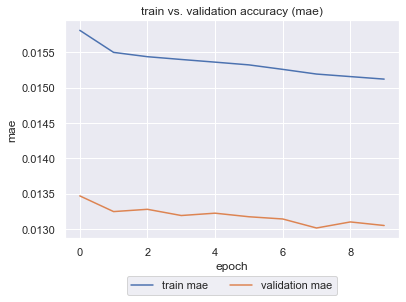

Training time was 64976.40 [s].



In [21]:
startTime = time.time()

trainX = X
trainY = Y

model_lstm = define_model(trainX, trainY, n_layers=n_layers, n_hidden=n_hidden, drop_rate=drop_rate)

model_lstm, train_mae, valid_mae = train_model(trainX, trainY, model_lstm)

model_lstm.save(f'model_lstm.h5')

plot_mae(train_mae, valid_mae)

print(f'Training time was {time.time() - startTime:.2f} [s].\n')

In [62]:
## Predict in test data
y_pred_lstm = model_lstm.predict(X_test)

In [36]:
test_prices = prices[prices['Date']>='20211201']

test_prices["Date"] = pd.to_datetime(test_prices["Date"])
test_prices.set_index('Date', inplace=True)

In [37]:
listFeatures = ['Open', 'High', 'Low', 'Close', 'Volume', 'AdjustmentFactor', 'SupervisionFlag', 'delta', 'RA_20','RA_40', 'RA_60', 'year', 'month', 'day', 'Quarter']
test_prices[listFeatures] = test_prices[listFeatures].apply(np.log1p)
test_prices

,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,SupervisionFlag,Target,delta,change,RA_20,RA_40,RA_60,year,month,day,Quarter
Date,,,,,,,,,,,,,,,,,,
2021-12-01,1301,7.975908,7.985144,7.975908,7.976595,9.268704,0.693147,0.0,0.016706,3.332205,2.0,7.990712,8.005267,8.015041,7.611842,2.564949,0.693147,1.609438
2021-12-01,1332,6.343880,6.361302,6.343880,6.354370,14.323112,0.693147,0.0,0.020942,2.397895,6.0,6.361993,6.377407,6.395929,7.611842,2.564949,0.693147,1.609438
2021-12-01,1333,7.725771,7.744137,7.725330,7.740664,11.881734,0.693147,0.0,0.023882,3.784190,34.0,7.743703,7.757693,7.771966,7.611842,2.564949,0.693147,1.609438
2021-12-01,1375,7.103322,7.123673,7.103322,7.116394,12.145266,0.693147,0.0,0.018977,3.258097,16.0,7.133615,7.165030,7.187758,7.611842,2.564949,0.693147,1.609438
2021-12-01,1376,7.190676,7.226209,7.190676,7.210818,8.343078,0.693147,0.0,0.003768,3.891820,27.0,7.231142,7.245084,7.253376,7.611842,2.564949,0.693147,1.609438
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-03,9990,6.244167,6.270988,6.242223,6.270988,10.696503,0.693147,0.0,0.034816,2.772589,14.0,6.257668,6.289344,6.316442,7.611842,2.564949,1.386294,1.609438
2021-12-03,9991,6.663133,6.678342,6.663133,6.678342,10.488520,0.693147,0.0,0.025478,2.564949,12.0,6.656212,6.673551,6.681941,7.611842,2.564949,1.386294,1.609438
2021-12-03,9993,7.433075,7.433075,7.406103,7.406103,8.881975,0.693147,0.0,-0.004302,3.828641,-45.0,7.418301,7.434021,7.439794,7.611842,2.564949,1.386294,1.609438


In [38]:
test_prices[listFeatures] = mm.transform(test_prices[listFeatures])


In [39]:
y_test = test_prices.pop('Target')
X_test = test_prices

In [ ]:
##Evaluate the model

#Mean Squared Error (MSE)
mse_lstm = mean_squared_error(y_test, y_pred_lstm)
#Mean Absolute Error (MAE)
mae_lstm = mean_absolute_error(y_test, y_pred_lstm)
#Mean Absolute Percentage Error (MAPE)
mape_lstm = mean_absolute_percentage_error(y_test, y_pred_lstm)
#Root Mean Squared Error (RMSE)
rmse_lstm = mean_squared_error(y_test, y_pred_lstm, squared = False)

print("Mean Squared Error: ", mse_lstm)
print("Mean Absolute Error: ", mae_lstm)
print("Mean Absolute Percentage Error: ", mape_lstm)
print("Root Mean Squared Error: ", rmse_lstm)

In [ ]:
sharp_dataframe['Target'] = y_pred_lstm
buf = sharp_dataframe.groupby('Date').apply(_calc_spread_return_per_day)
sharpe_ratio_lstm = buf.mean() / buf.std()
print(sharpe_ratio_lstm)
sharp_dataframe.drop('Target', axis=1, inplace=True)
sharp_dataframe

In [41]:
def prepare_data(df, listSC, listFeatures, mm):
    '''Pre-processing and prepare dataset.'''
    
    X = []
    for sc in tqdm(listSC):
        dfTemp = df[df['SecuritiesCode'] == sc]
        dfTemp[listFeatures] = dfTemp[listFeatures].apply(np.log1p)
        dfTemp[listFeatures] = mm.transform(dfTemp[listFeatures])
        dfTemp = dfTemp.interpolate()
        dfTemp = dfTemp.fillna(0)
        x = dfTemp[listFeatures].to_numpy()
        X.append(x)
        
    X = np.array(X)
    assert X.shape == (len(listSC), TIME_WINDOW, len(listFeatures)), "Shape of X is not correct."
    return X

In [42]:
def predict_rank(X, model, sample_prediction, listSC):
    '''Predict Target value and make a ranking. Return submittion df.'''
    
    Y = model.predict(X)
    dfY = pd.DataFrame(Y.reshape(-1, 1))
    dfSC = pd.DataFrame(listSC)
    dfTemp = pd.concat([dfSC, dfY], axis=1)
    dfTemp.columns = ['SecuritiesCode', 'prediction']
    dfTemp['Rank'] = dfTemp["prediction"].rank(ascending=False,method="first") -1
    dfTemp['Rank'] = dfTemp['Rank'].astype(int)
    dfTemp = dfTemp.drop('prediction', axis=1)
    sample_prediction = sample_prediction.drop('Rank', axis=1)
    dfSub = sample_prediction.merge(dfTemp, on='SecuritiesCode', how='left')

    assert dfSub.shape == (len(listSC), 3), "Shape of dfSub is not correct."
    return dfSub 

In [ ]:
def _calc_spread_return_per_day(df, portfolio_size= 200, toprank_weight_ratio= 2):
    """
    Args:
        df (pd.DataFrame): predicted results
        portfolio_size (int): # of equities to buy/sell
        toprank_weight_ratio (float): the relative weight of the most highly ranked stock compared to the least.
    Returns:
        (float): spread return
    """
    df["Rank"] = df["Target"].rank(ascending=False,method="first") -1
    weights = np.linspace(start=toprank_weight_ratio, stop=1, num=portfolio_size)
    purchase = (df.sort_values(by='Rank')['Target'][:portfolio_size] * weights).sum() / weights.mean()
    short = (df.sort_values(by='Rank', ascending=False)['Target'][:portfolio_size] * weights).sum() / weights.mean()
    return purchase - short
buf = prices.groupby('Date').apply(_calc_spread_return_per_day)
sharpe_ratio = buf.mean() / buf.std()
sharpe_ratio

In [ ]:
import jpx_tokyo_market_prediction
env = jpx_tokyo_market_prediction.make_env()
iter_test = env.iter_test()


count = 0
countExcept = 0

# Prepare dataframe with past data for prediction.
dfPrice = pd.read_csv(PATH_INPUT + r'/train_files/stock_prices.csv', usecols=['Date', 'SecuritiesCode', 'Open', 'High', 'Low', 'Close', 'Volume'])
dfPrice['Date'] = pd.to_datetime(dfPrice['Date'])
dfPrice.set_index('Date', inplace=True)
dfPrice = dfPrice.loc[TRAIN_PERIOD[0]:TRAIN_PERIOD[1],:]
dfPrice



In [ ]:
for (prices, options, financials, trades, secondary_prices, sample_prediction) in iter_test:
    try:
        prices = prices[['Date', 'SecuritiesCode', 'Open', 'High', 'Low', 'Close', 'Volume']]
        prices['Date'] = pd.to_datetime(prices['Date'])
        prices.set_index('Date', inplace=True)
        
        dfPrice = pd.concat([dfPrice, prices], axis=0)
        dfTarget = dfPrice.tail(TIME_WINDOW*2000)  # Number of Target code is 2000 and each code need data "TIME_WINDOW" 
        X = prepare_data(dfTarget, listSC, listFeatures, mm)
        dfSub = predict_rank(X, model, sample_prediction, listSC)
        
        if DEBUG:
            display(dfSub)
        
        env.predict(dfSub)
        count += 1
              
    except:
        env.predict(sample_prediction)
        count += 1
        countExcept += 1

In [ ]:
print(f'Finished prediction. {countExcept} / {count} times exception occurred. \n')

In [22]:
loss = [5.1579e-04, 5.0193e-04, 4.9965e-04, 4.9726e-04, 4.9531e-04, 4.9344e-04, 4.8998e-04, 4.8651e-04, 4.8473e-04, 4.8305e-04]

In [23]:
def plot_loss(loss):
    plt.plot(loss),
    #plt.plot(valid_mae, label='validation mae')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    #plt.title('train vs. validation accuracy (mae)')
    #plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=
    #2)
    plt.show()

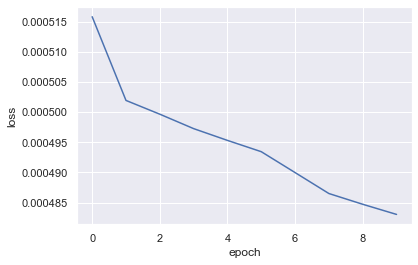

In [24]:
plot_loss(loss)

In [60]:
score = [-0.183, 2.329, -0.115, 0.557, 0.314, 2.477, 2.695]
models = ["LR","k-NNN",'SVR','RF','AdaBoost','XGBoost','LSTM']
X_axis = np.arange(len(models))


No handles with labels found to put in legend.


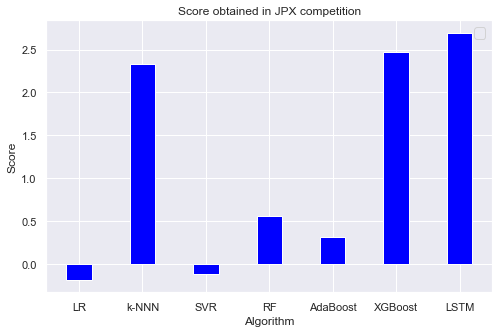

In [61]:
f, ax = plt.subplots(figsize=(8,5)) 
plt.bar(X_axis, score, color ='blue',
        width = 0.4)
 
plt.xlabel("Algorithm")
plt.ylabel("Score")
plt.title("Score obtained in JPX competition")
plt.xticks(X_axis, models)
ax.legend(fontsize = 14)
plt.show()